# Transfer Learning 실습

## Import modules

In [1]:
# tensorflow data 설치
! pip install tensorflow-datasets

You should consider upgrading via the 'c:\users\hyun\python.exe -m pip install --upgrade pip' command.


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

## 하이퍼파라미터 정의

In [3]:
EPOCHS = 50

## 네트워크 구조 정의

In [4]:
# CNN할 때처럼 함수로 정의해서 keras형태로 
def MyModel():
    feat = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                            # input_shape(image_height, image_width, color_channels)
                                            include_top=False) # True면 MobileNetV2이 imageNet을 학습될 때 달려있던 FC Layer를 포함한다는 뜻
                                            # False니까 FC Layer는 떼고 Conv만 가져온다는 것, 우리는 뒷부분 합쳐줘서 다시 학습할거기때문에
    feat.trainable = False # 앞쪽은 FREEZE를 한다고했었지
    
    seq = tf.keras.models.Sequential()
    # 이전에는 Sequential([])안에 넣어줬었는데 다른 방식도 알아보자
    # Sequential을 변수 seq로 받아둔 다음에 add 활용
    seq.add(feat) # 만약 h x w x c 크기로 나왔다고 했을 때
    seq.add(tf.keras.layers.GlobalAveragePooling2D()) # c, 위 크기를 전부 pooling해줘서 채널 크기만 남겨줌
    seq.add(tf.keras.layers.Dense(1, activation='sigmoid')) # binary classification
    # 우리가 학습하고 있는 것은 이 dense layer 딱 1개 뿐!
    
    return seq

## 데이터 불러오기 (Cats vs. Dogs)

In [5]:
# 데이터셋이 train, validation, test 등 구분이 안되어있기때문에 먼저 split 해줘야 해
#split = tfds.Split.TRAIN.subsplit(weighted=(8,2)) # Train set을 8:2로 데이터 나눠줌
dataset, meta = tfds.load('cats_vs_dogs',
                          split=['train[:80%]', 'train[-20%:]'], # split 파라미터에 우리가 구현한 split을 리스트로 넣어줘
                         # 우리가 구현한 split은 iterater로 받아오기때문에 리스트로 입력받아줘야함
                          with_info=True, # 정보를 같이 받아옴(meta를 같이 받아옴)
                          as_supervised=True) # 데이터를 (input, label) 튜플 형태로 반환 - 우린 label까지 받아올 것이기 때문에

train_ds, test_ds = dataset # 8:2로 나뉘어져서 들어옴

## 데이터 확인하기

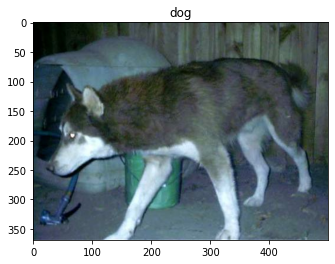

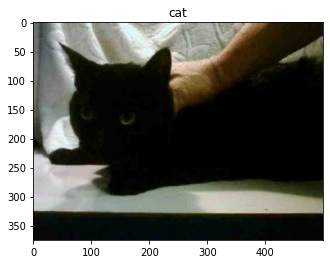

In [6]:
l2s = meta.features['label'].int2str # label을 string으로 바꿔주는 함수

# 2개 정도 받아서 그림으로 확인해보자
for img, label in test_ds.take(2):
    plt.figure()
    plt.imshow(img)
    plt.title(l2s(label)) # 받아온 label을 str형태로 바꿔서 적어줘

## 데이터 가공하기

In [7]:
# 모델 생성할 때 (224, 224, 3)크기의 영상을 쓰려고하고있기때문에
# 데이터를 (224, 224, 3)이 크기로 따로 가공해줘야해 (지금은 크기가 다 달라)

# 데이터셋이 구축되어있는 상태에서 데이터셋을 사용할 때마다 원하는 크기로 preprocessing해주는 과정
def preprocess(img, label):
    img = tf.cast(img, tf.float32) / 225.0 # 현재 데이터셋은 0~225로 저장되어있는데, 0~1사이로 캐스팅되게끔 normalization
    img = tf.image.resize(img, (224, 224))
    return img, label # img는 가공되어서, label은 그대로 return

# dataset에 적용
train_ds = train_ds.map(preprocess).batch(32).prefetch(1024) # prefetch 사용하여 속도 올림
test_ds = test_ds.map(preprocess).batch(32).prefetch(1024)

## 모델 생성

In [8]:
model = MyModel()
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

## 모델 학습

In [ ]:
model.fit(train_ds, validation_data=test_ds, epochs=EPOCHS)

Epoch 1/50
582/582 [==============================] - 5405s 9s/step - loss: 0.1635 - accuracy: 0.9357 - val_loss: 0.1269 - val_accuracy: 0.9529
Epoch 2/50
 37/582 [>.............................] - ETA: 1:12:59 - loss: 0.0929 - accuracy: 0.9679